# Greenest Pixel Composite

For a given analysis tile, use a time series analysis to select greenest pixels for the time window. Based on the Greenest pixel select matching pixels from other bands to use in the derivation of covariates related to plant indicators.

In [14]:
import json
import os
import rasterio as rio
import geopandas as gpd
from shapely.geometry import box
from fiona.crs import from_epsg
from rasterio.mask import mask
from rasterio.warp import *
from rasterio.merge import merge
from rasterio import windows
import numpy as np
import matplotlib.pyplot as plt
#import rioxarray as rxr

import sys


In [3]:
# Get bbox extent
geojson_path = '/projects/maap-users/alexdevseed/boreal_tiles_latlong.geojson'
bbox_ID = 41722
#in_crs = CRS.from_epsg(4326)

# open geojson and get co-ords of tile ID
with open(geojson_path) as j:
        response = json.load(j)
        in_bbox = rio.features.bounds(response['features'][bbox_ID-1]['geometry'])

print('in_bbox = ', in_bbox)


in_bbox =  (-116.4, 49.7, -116.1, 50.0)


In [4]:
# TODO: Clean up by using var for first part of datapath
GeoJson_file = '/projects/maap-users/alexdevseed/landsat8/sample2/'
## open json
## parses json file and returns local filepaths
## outputs a listof the local filepaths
def GetBandLists(inJSON, bandnum):
    with open(inJSON) as f:
        response = json.load(f)
    
    BandList = []
    for i in range(len(response.keys())):
        try:
            getBand = response['features'][i]['assets']['SR_B' + str(bandnum) + '.TIF']['href']
            BandList.append(getBand)
        except exception as e:
            print(e)

    BandList.sort()
    return BandList


BLUEBands = GetBandLists(os.path.join(GeoJson_file,'local-2018.json'), 2)
GREENBands = GetBandLists(os.path.join(GeoJson_file,'local-2018.json'), 3)
REDBands = GetBandLists(os.path.join(GeoJson_file,'local-2018.json'), 4)
NIRBands = GetBandLists(os.path.join(GeoJson_file,'local-2018.json'), 5)
SWIRBands = GetBandLists(os.path.join(GeoJson_file,'local-2018.json'), 6)

print("file locations of red bands over ROI = ", REDBands)
print("file locations of nir bands over ROI = ", NIRBands)

#LS8_file = BLUEBands[0]

file locations of red bands over ROI =  ['/projects/alexdevseed/landsat8/sample2/LC08_L2SP_042024_20180907_20200831_02_T1/LC08_L2SP_042024_20180907_20200831_02_T1_SR_B4.TIF', '/projects/alexdevseed/landsat8/sample2/LC08_L2SP_042025_20180907_20200831_02_T1/LC08_L2SP_042025_20180907_20200831_02_T1_SR_B4.TIF', '/projects/alexdevseed/landsat8/sample2/LC08_L2SP_044024_20180905_20200831_02_T1/LC08_L2SP_044024_20180905_20200831_02_T1_SR_B4.TIF', '/projects/alexdevseed/landsat8/sample2/LC08_L2SP_044025_20180905_20200831_02_T1/LC08_L2SP_044025_20180905_20200831_02_T1_SR_B4.TIF']
file locations of nir bands over ROI =  ['/projects/alexdevseed/landsat8/sample2/LC08_L2SP_042024_20180907_20200831_02_T1/LC08_L2SP_042024_20180907_20200831_02_T1_SR_B5.TIF', '/projects/alexdevseed/landsat8/sample2/LC08_L2SP_042025_20180907_20200831_02_T1/LC08_L2SP_042025_20180907_20200831_02_T1_SR_B5.TIF', '/projects/alexdevseed/landsat8/sample2/LC08_L2SP_044024_20180905_20200831_02_T1/LC08_L2SP_044024_20180905_2020083

In [24]:
## read all bands as masked arrays
## read each object in each list as a masked array 

def MaskArrays(file, in_bbox, epsg="epsg:4326"):
    print(file)
    with rio.open(file, 'r') as f:
        bbox = transform_bounds(epsg, f.crs, *in_bbox)
        w = windows.from_bounds(*bbox, transform=f.transform)
        #band = f.read(1, window=w, masked=True)
        band, out_transform = merge([f],bounds=bbox)
        print(band[0].shape)
    return band[0].astype(float)


def CreateNDVIstack(REDfile, NIRfile, in_bbox):
    print("Creating NDVI layer ")
    NIRarr = MaskArrays(NIRfile, in_bbox)
    REDarr = MaskArrays(REDfile, in_bbox) 
    return np.ma.array((NIRarr-REDarr)/(NIRarr+REDarr))



In [25]:
## create NDVI layers
## Loopsover lists of bands and calculates NDVI
## creates a new list of NDVI images, one per input scene

# tmp hack to subset list
redFiles = [REDBands[x] for x in [1,3]]
NIRFiles = [NIRBands[x] for x in [1,3]]
greenFiles = [GREENBands[x] for x in [1,3]]
blueFiles = [BLUEBands[x] for x in [1,3]]
SWIRFiles = [SWIRBands[x] for x in [1,3]]


NDVIstack = [CreateNDVIstack(redFiles[i],NIRFiles[i],in_bbox) for i in range(len(redFiles))]
print(np.shape(NDVIstack))
print('finished')


Creating NDVI layer 
/projects/alexdevseed/landsat8/sample2/LC08_L2SP_042025_20180907_20200831_02_T1/LC08_L2SP_042025_20180907_20200831_02_T1_SR_B5.TIF
(1119, 731)
/projects/alexdevseed/landsat8/sample2/LC08_L2SP_042025_20180907_20200831_02_T1/LC08_L2SP_042025_20180907_20200831_02_T1_SR_B4.TIF
(1119, 731)
Creating NDVI layer 
/projects/alexdevseed/landsat8/sample2/LC08_L2SP_044025_20180905_20200831_02_T1/LC08_L2SP_044025_20180905_20200831_02_T1_SR_B5.TIF
(1119, 731)
/projects/alexdevseed/landsat8/sample2/LC08_L2SP_044025_20180905_20200831_02_T1/LC08_L2SP_044025_20180905_20200831_02_T1_SR_B4.TIF
(1119, 731)
(2, 1119, 731)
finished


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


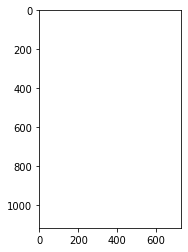

In [28]:
#print(NDVIstack[0])

plt.imshow(NDVIstack[0])
#plt.imshow(NDVIstack[1])
#plt.imshow(NDVIstack[2])


0
0
(2, 1119, 731)


TypeError: Invalid shape () for image data

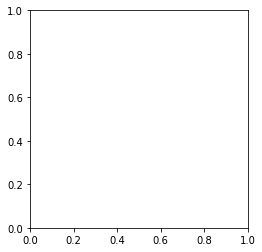

In [29]:
print(np.argmin(NDVIstack))
print(np.argmax(NDVIstack))
print(np.shape(NDVIstack))

MaxNDVI = np.ma.max(np.ma.array(NDVIstack),axis=0)
BoolMask = np.ma.getmask(MaxNDVI)

del MaxNDVI

plt.imshow(BoolMask)
print(BoolMask)

(13301, 11871)


Text(0, 0.5, '$\\bf{Image Location}$')

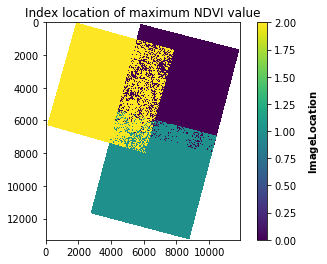

In [7]:
## get the index positions of the max NDVI value
## Get the argmax index positions from the stack of NDVI images

#Avoid slice of all nan
#NDVIstack[NDVIstack==np.nan] = 0

NDVIstack = np.ma.array(NDVIstack)
NDVImax = np.nanargmax(NDVIstack,axis=0)
print(np.shape(NDVImax))
## create a tmp array (binary mask) of the same input shape
NDVItmp = np.ma.zeros(NDVIstack.shape, dtype=bool)

## for each dimension assign the index position (flattens the array to a LUT)
for i in range(np.shape(NDVIstack)[0]):
    NDVItmp[i,:,:]=NDVImax==i
    

plt.imshow(np.ma.masked_array(NDVImax, BoolMask), cmap='viridis')
plt.title("Index location of maximum NDVI value")
cbar1 = plt.colorbar()
cbar1.ax.set_ylabel(r"$\bf{Image Location}$",  labelpad=10, rotation=90)  
#plt.savefig('/projects/bobafett/LandsatComposites/Landsat_MaxNDVIIdx.png', format='PNG')

In [8]:
## Return Red value based on NDVI max index position

# insert the bands as arrays (made earlier)
## creates a single layer by using the binary mask
## and a sum function to collapse n-dims to 2-dims
def CollapseBands(inArr, NDVItmp, BoolMask):
    inArr = np.ma.masked_equal(inArr, 0)
    inArr[np.logical_not(NDVItmp)]=0 
    compImg = np.ma.masked_array(inArr.sum(0), BoolMask)
    
    return compImg
# TODO
def Write_to_disk():

    
def CreateComposite(file_list, NDVItmp, BoolMask):
    MaskedFiles = [MaskArrays(file_list[i]) for i in range(len(file_list))]
    Composite=CollapseBands(MaskedFiles, NDVItmp, BoolMask)
    # write files to disk here
    return Composite




In [9]:
RedComp = CreateComposite(redFiles, NDVItmp, BoolMask)
BlueComp = CreateComposite(blueFiles, NDVItmp, BoolMask)
GreenComp = CreateComposite(greenFiles, NDVItmp, BoolMask)

/projects/bobafett/LandsatComposites/LC08_L2SP_031028_20180910_20200830_02_T1_SR_B4_warp.tif
/projects/bobafett/LandsatComposites/LC08_L2SP_031029_20180825_20200831_02_T1_SR_B4_warp.tif
/projects/bobafett/LandsatComposites/LC08_L2SP_032028_20180816_20200831_02_T1_SR_B4_warp.tif
/projects/bobafett/LandsatComposites/LC08_L2SP_031028_20180910_20200830_02_T1_SR_B2_warp.tif
/projects/bobafett/LandsatComposites/LC08_L2SP_031029_20180825_20200831_02_T1_SR_B2_warp.tif
/projects/bobafett/LandsatComposites/LC08_L2SP_032028_20180816_20200831_02_T1_SR_B2_warp.tif
/projects/bobafett/LandsatComposites/LC08_L2SP_031028_20180910_20200830_02_T1_SR_B3_warp.tif
/projects/bobafett/LandsatComposites/LC08_L2SP_031029_20180825_20200831_02_T1_SR_B3_warp.tif
/projects/bobafett/LandsatComposites/LC08_L2SP_032028_20180816_20200831_02_T1_SR_B3_warp.tif


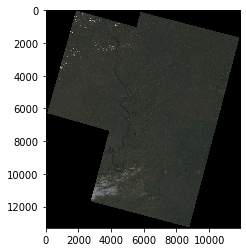

In [10]:
# TEST CELLS AND PLOTS

def norm(band):
    band_min, band_max = band.min(), band.max()
    scale = ((band - band_min)/(band_max - band_min))*255
    return scale.astype(np.ubyte)

def RGBstack(b2, b3, b4):
    b2 = norm(b2)
    b3 = norm(b3)
    b4 = norm(b4)

    rgb = np.ma.dstack((b4,b3,b2))

    return rgb

rgb = RGBstack(BlueComp,GreenComp,RedComp)

plt.imshow(rgb)

# hack to free up memory
del rgb, BlueComp, GreenComp
#del BlueComp, GreenComp, rgb
#cbar1.ax.set_ylabel(r"$\bf{Reflectance}$",  labelpad=10, rotation=90)  
#plt.savefig('/projects/bobafett/LandsatComposites/Landsat_RGBComposite.png', format='PNG')

In [11]:
## Create Indices of interest from new composites
NIRComp = CreateComposite(NIRFiles, NDVItmp, BoolMask)


/projects/bobafett/LandsatComposites/LC08_L2SP_031028_20180910_20200830_02_T1_SR_B5_warp.tif
/projects/bobafett/LandsatComposites/LC08_L2SP_031029_20180825_20200831_02_T1_SR_B5_warp.tif
/projects/bobafett/LandsatComposites/LC08_L2SP_032028_20180816_20200831_02_T1_SR_B5_warp.tif
calculating Red edge (Simple ratio)...


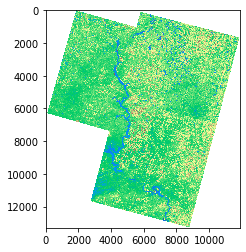

In [12]:
plt.imshow(np.ma.masked_array(REComp, BoolMask), cmap="terrain")